In [1]:
# processing
import math
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)
promoter

'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

### Simple repression

In [5]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

In [6]:
mutant_bank = []
for i in range(10):
    mutants = np.unique(tregs.wgregseq.mutations_rand(promoter,
                                                rate=0.1,
                                                num_mutants=5000,
                                                number_fixed=True,
                                                keep_wildtype=True))
    mutant_bank.append(mutants)

In [7]:
n_NS = len(genome)
n_p = 4600
n_r = 0
ep_wt = -5
er_wt = -15

l_n_r = np.arange(0, 1000, 10)

rnap_signal = []
rep_signal = []
for n_r in l_n_r:
    rnap = []
    rep = []
    for i in range(10):
        df = tregs.simulate.sim_preset_library(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                                               *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                                               mutants=mutant_bank[i],
                                               scaling_factor=10**6)

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        nbins = 2
        upper_bound = np.mean(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        rnap.append((np.mean(footprint[(-38+115):(-30+116)]) + np.mean(footprint[(-15+115):(-5+116)]))/2)
        rep.append(np.mean(footprint[(2+115):(17+116)]))
    rnap_signal.append(np.mean(rnap))
    rep_signal.append(np.mean(rep))

In [12]:
np.log(4 * 10**5)

12.89921982609012

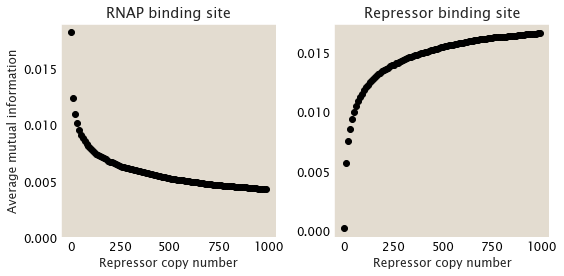

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax1, ax2 = axes
ax1.scatter(l_n_r, rnap_signal, color='k')
ax1.set_xlabel('Repressor copy number')
ax1.set_ylabel('Average mutual information')
ax1.set_title('RNAP binding site')
ax1.set_yticks([0, 0.005, 0.01, 0.015])

ax2.scatter(l_n_r, rep_signal, color='k')
ax2.set_xlabel('Repressor copy number')
ax2.set_title('Repressor binding site')
ax2.set_yticks([0, 0.005, 0.01, 0.015])

plt.tight_layout()
plt.savefig('../../figs/repressor_copy_number.png', dpi=300)

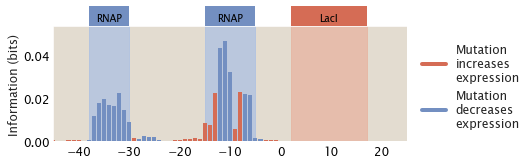

In [33]:
n_NS = len(genome)
n_p = 4600
n_r = 0
ep_wt = -5
er_wt = -15

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False,
                               x_lims=(-45, 25), fig_width=8,
                               legend_xcoord=1.35,
                               outfile='../../figs/repressor_copy_number_footprint1.png')

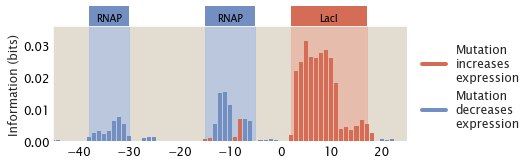

In [34]:
n_NS = len(genome)
n_p = 4600
n_r = 500
ep_wt = -5
er_wt = -15

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False,
                               x_lims=(-45, 25), fig_width=8,
                               legend_xcoord=1.35,
                               outfile='../../figs/repressor_copy_number_footprint2.png')

### Simple activation

In [11]:
# CRP binding site
crp_site = 'ATTAATGTGAGTTAGCTCACTCATTA'

crp_emat_raw = pd.read_table('../../data/energy_matrices/crp_tau_final_all_26.txt', delim_whitespace=True)
crp_emat = crp_emat_raw[['par_A', 'par_C', 'par_G', 'par_T']].to_numpy().T * 1.62

In [12]:
mutant_bank = []
for i in range(10):
    mutants = np.unique(tregs.wgregseq.mutations_rand(promoter,
                                                rate=0.1,
                                                num_mutants=5000,
                                                number_fixed=True,
                                                keep_wildtype=True))
    mutant_bank.append(mutants)

In [13]:
n_NS = len(genome)
n_p = 1000
ep_wt = -3
ea_wt = -20
e_ap = -10

l_n_a = np.arange(0, 1000, 10)

rnap_signal = []
act_signal = []
for n_a in l_n_a:
    rnap = []
    act = []
    for i in range(10):
        df = tregs.simulate.sim_preset_library(promoter, tregs.simulate.simact_pbound, [rnap_site, crp_site], 
                                               *[n_NS, n_p, n_a, rnap_emat, crp_emat, ep_wt, ea_wt, e_ap],
                                               mutants=mutant_bank[i],
                                               scaling_factor=10**6)

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        nbins = 2
        upper_bound = np.mean(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        rnap.append((np.mean(footprint[(-38+115):(-30+116)]) + np.mean(footprint[(-15+115):(-5+116)]))/2)
        act.append(np.mean(footprint[(-70+115):(-52+116)]))
    rnap_signal.append(np.mean(rnap))
    act_signal.append(np.mean(act))

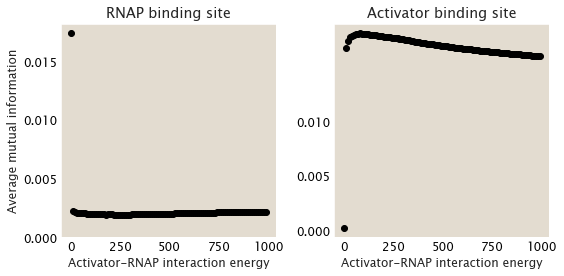

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax1, ax2 = axes
ax1.scatter(l_n_a, rnap_signal, color='k')
ax1.set_xlabel('Activator-RNAP interaction energy')
ax1.set_ylabel('Average mutual information')
ax1.set_title('RNAP binding site')
ax1.set_yticks([0, 0.005, 0.01, 0.015])

ax2.scatter(l_n_a, act_signal, color='k')
ax2.set_xlabel('Activator-RNAP interaction energy')
ax2.set_title('Activator binding site')
ax2.set_yticks([0, 0.005, 0.01])

plt.tight_layout()
plt.savefig('../../figs/activator_copy_number.png', dpi=300)

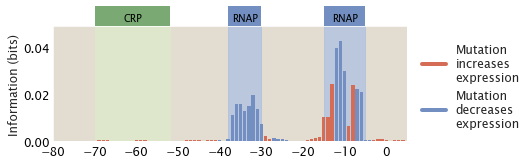

In [9]:
n_NS = len(genome)
n_p = 5000
n_a = 0
ep_wt = -3
ea_wt = -13
e_ap = -10

df = tregs.simulate.sim(promoter, tregs.simulate.simact_pbound, [rnap_site, crp_site], 
                        *[n_NS, n_p, n_a, rnap_emat, crp_emat, ep_wt, ea_wt, e_ap])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'CRP')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False,
                               x_lims=(-80, 5), fig_width=8,
                               legend_xcoord=1.35,
                               outfile='../../figs/activator_copy_number_footprint1.png')

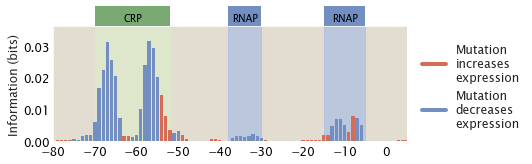

In [10]:
n_NS = len(genome)
n_p = 5000
n_a = 500
ep_wt = -3
ea_wt = -13
e_ap = -10

df = tregs.simulate.sim(promoter, tregs.simulate.simact_pbound, [rnap_site, crp_site], 
                        *[n_NS, n_p, n_a, rnap_emat, crp_emat, ep_wt, ea_wt, e_ap])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'CRP')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False,
                               x_lims=(-80, 5), fig_width=8,
                               legend_xcoord=1.35,
                               outfile='../../figs/activator_copy_number_footprint2.png')

### Double repression

In [40]:
rep1_site = promoter[(115-70):(115-60)]
rep2_site = promoter[(115-50):(115-40)]
r1_emat = tregs.simulate.generate_emap(rep1_site, fixed=True, fixed_value=1)
r2_emat = tregs.simulate.generate_emap(rep2_site, fixed=True, fixed_value=1)

In [41]:
mutant_bank = []
for i in range(10):
    mutants = np.unique(tregs.wgregseq.mutations_rand(promoter,
                                                rate=0.1,
                                                num_mutants=5000,
                                                number_fixed=True,
                                                keep_wildtype=True))
    mutant_bank.append(mutants)

In [42]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -14, -14
e_int = -5
n_p, n_r2 = 4600, 25

l_n_r1 = np.arange(0, 50, 1)

r1_signal_AND = []
r2_signal_AND = []

for n_r1 in l_n_r1:
    r1 = []
    r2 = []
    for i in range(10):
        df = tregs.simulate.sim_preset_library(promoter, tregs.simulate.doublerep_pbound,
                                               [rnap_site, rep1_site, rep2_site],
                                               *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'AND'],
                                               mutants=mutant_bank[i],
                                               scaling_factor=10**6)

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        nbins = 2
        upper_bound = np.mean(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        r1.append(np.mean(footprint[(-70+115):(-60+115)]))
        r2.append(np.mean(footprint[(-50+115):(-40+115)]))
    r1_signal_AND.append(np.mean(r1))
    r2_signal_AND.append(np.mean(r2))

In [43]:
r1_signal_OR = []
r2_signal_OR = []

for n_r1 in l_n_r1:
    r1 = []
    r2 = []
    for i in range(10):
        df = tregs.simulate.sim_preset_library(promoter, tregs.simulate.doublerep_pbound,
                                               [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'OR'],
                        mutants=mutant_bank[i],
                        scaling_factor=10**6)

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        nbins = 2
        upper_bound = np.mean(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        r1.append(np.mean(footprint[(-70+115):(-60+115)]))
        r2.append(np.mean(footprint[(-50+115):(-40+115)]))
    r1_signal_OR.append(np.mean(r1))
    r2_signal_OR.append(np.mean(r2))

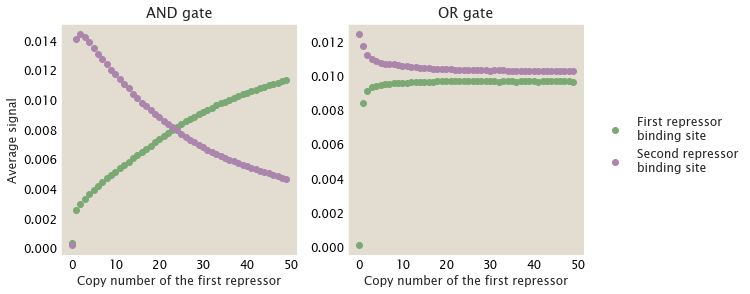

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(11,4.25))
ax1, ax2 = axes

ax1.scatter(l_n_r1, r2_signal_AND, label='Second repressor\nbinding site', color='#7AA974')
ax1.scatter(l_n_r1, r1_signal_AND, label='First repressor\nbinding site', color='#AB85AC')
ax1.set_xlabel('Copy number of the first repressor')
ax1.set_ylabel('Average signal')
ax1.set_title('AND gate')

ax2.scatter(l_n_r1, r1_signal_OR, label='First repressor\nbinding site', color='#7AA974')
ax2.scatter(l_n_r1, r2_signal_OR, label='Second repressor\nbinding site', color='#AB85AC')
ax2.set_xlabel('Copy number of the first repressor')
ax2.set_title('OR gate')
ax2.legend(bbox_to_anchor=(1.7, 0.65), frameon=False)

plt.tight_layout()
plt.savefig('../../figs/knockout_doublerep.png', dpi=300)

In [50]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -14, -14
e_int = -5
n_p, n_r2 = 4600, 25

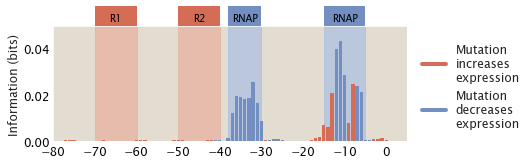

In [51]:
n_r1 = 0

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'AND'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -60, 'R', 'R1'), (-50, -40, 'R', 'R2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-80, 5), fig_width=8,
                               legend_xcoord=1.35,
                               outfile='../../figs/knockout_doublerep_footprint1.png')

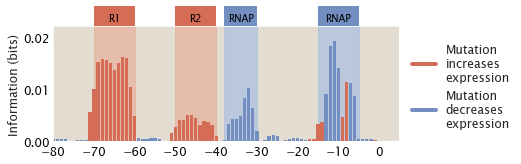

In [59]:
n_r1 = 5

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'AND'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -60, 'R', 'R1'), (-50, -40, 'R', 'R2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-80, 5), fig_width=8,
                               legend_xcoord=1.35,
                               outfile='../../figs/knockout_doublerep_footprint2.png')

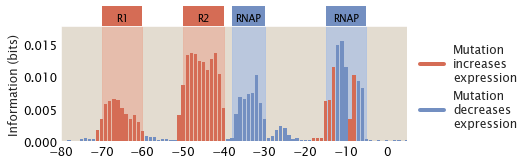

In [60]:
n_r1 = 50
df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'AND'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -60, 'R', 'R1'), (-50, -40, 'R', 'R2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-80, 5), fig_width=8,
                               legend_xcoord=1.35,
                               outfile='../../figs/knockout_doublerep_footprint3.png')

In [54]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -14, -14
e_int = -5
n_p, n_r2 = 4600, 25

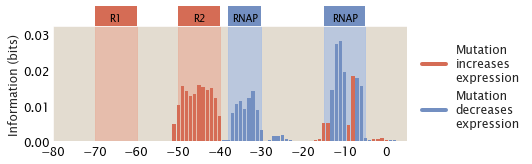

In [61]:
n_r1 = 0

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'OR'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -60, 'R', 'R1'), (-50, -40, 'R', 'R2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-80, 5), fig_width=8,
                               legend_xcoord=1.35,
                               outfile='../../figs/knockout_doublerep_footprint4.png')

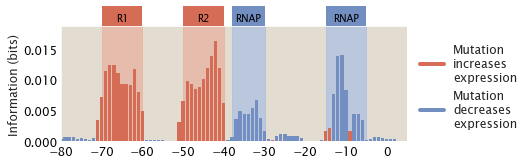

In [62]:
n_r1 = 5

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'OR'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -60, 'R', 'R1'), (-50, -40, 'R', 'R2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-80, 5), fig_width=8,
                               legend_xcoord=1.35,
                               outfile='../../figs/knockout_doublerep_footprint5.png') 

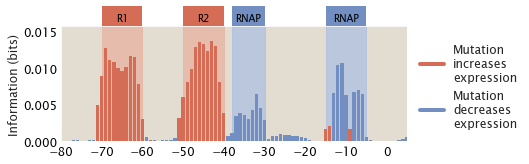

In [63]:
n_r1 = 50

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'OR'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -60, 'R', 'R1'), (-50, -40, 'R', 'R2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-80, 5), fig_width=8,
                               legend_xcoord=1.35,
                               outfile='../../figs/knockout_doublerep_footprint6.png')

### Double activation

In [67]:
act1_site = promoter[(115 - 110 + 15):(115 - 110 + 25)]
act2_site = promoter[(115 - 110 + 35):(115 - 110 + 45)]
a1_emat = tregs.simulate.generate_emap(act1_site, fixed=True, fixed_value=1)
a2_emat = tregs.simulate.generate_emap(act2_site, fixed=True, fixed_value=1)

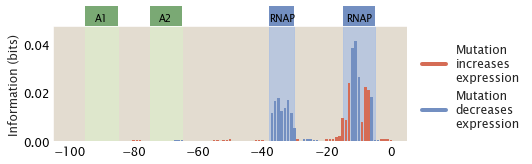

In [72]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2, e_int_a1a2 = -4, -4, -4
n_p, n_a1, n_a2 = 4600, 0, 25

df = tregs.simulate.sim(promoter, tregs.simulate.doubleact_pbound, [rnap_site, act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'AND'], scaling_factor=100)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-95, -85, 'A', 'A1'), (-75, -65, 'A', 'A2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-105, 5), fig_width=8, annotate_stn=False,
                               legend_xcoord=1.35,
                               outfile='../../figs/knockout_doubleact_footprint1.png')

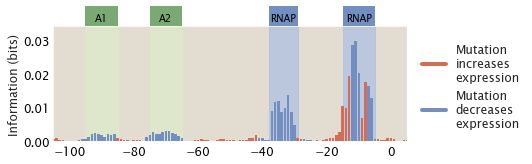

In [74]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2, e_int_a1a2 = -4, -4, -4
n_p, n_a1, n_a2 = 4600, 10, 25

df = tregs.simulate.sim(promoter, tregs.simulate.doubleact_pbound, [rnap_site, act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'AND'], scaling_factor=100)

region_params = [(-38, -29, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-95, -85, 'A', 'A1'), (-75, -65, 'A', 'A2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-105, 5), fig_width=8, annotate_stn=False,
                               legend_xcoord=1.35,
                               outfile='../../figs/knockout_doubleact_footprint2.png')

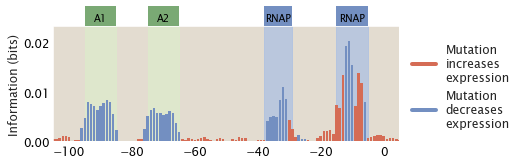

In [75]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2, e_int_a1a2 = -4, -4, -4
n_p, n_a1, n_a2 = 4600, 50, 25

df = tregs.simulate.sim(promoter, tregs.simulate.doubleact_pbound, [rnap_site, act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'AND'], scaling_factor=100)

region_params = [(-38, -29, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-95, -85, 'A', 'A1'), (-75, -65, 'A', 'A2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-105, 5), fig_width=8, annotate_stn=False,
                               legend_xcoord=1.35,
                               outfile='../../figs/knockout_doubleact_footprint3.png')

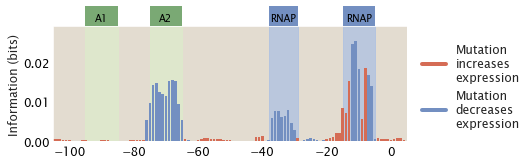

In [76]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2, e_int_a1a2 = -7, -7, -7
n_p, n_a1, n_a2 = 4600, 0, 25

df = tregs.simulate.sim(promoter, tregs.simulate.doubleact_pbound, [rnap_site, act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'OR'], scaling_factor=100)

region_params = [(-38, -29, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-95, -85, 'A', 'A1'), (-75, -65, 'A', 'A2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-105, 5), fig_width=8, annotate_stn=False,
                               legend_xcoord=1.35,
                               outfile='../../figs/knockout_doubleact_footprint4.png')

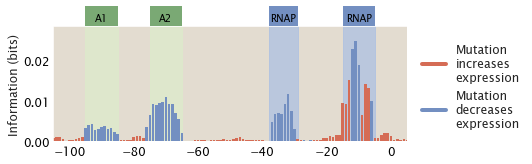

In [77]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2, e_int_a1a2 = -7, -7, -7
n_p, n_a1, n_a2 = 4600, 10, 25

df = tregs.simulate.sim(promoter, tregs.simulate.doubleact_pbound, [rnap_site, act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'OR'], scaling_factor=100)

region_params = [(-38, -29, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-95, -85, 'A', 'A1'), (-75, -65, 'A', 'A2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-105, 5), fig_width=8, annotate_stn=False,
                               legend_xcoord=1.35,
                               outfile='../../figs/knockout_doubleact_footprint5.png')

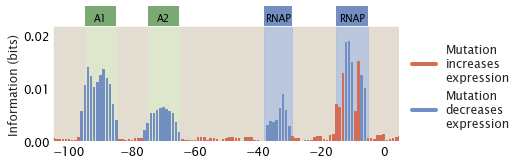

In [78]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2, e_int_a1a2 = -7, -7, -7
n_p, n_a1, n_a2 = 4600, 50, 25

df = tregs.simulate.sim(promoter, tregs.simulate.doubleact_pbound, [rnap_site, act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'OR'], scaling_factor=100)

region_params = [(-38, -29, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-95, -85, 'A', 'A1'), (-75, -65, 'A', 'A2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-105, 5), fig_width=8, annotate_stn=False,
                               legend_xcoord=1.35,
                               outfile='../../figs/knockout_doubleact_footprint6.png')

In [68]:
mutant_bank = []
for i in range(20):
    mutants = np.unique(tregs.wgregseq.mutations_rand(promoter,
                                                rate=0.1,
                                                num_mutants=5000,
                                                number_fixed=True,
                                                keep_wildtype=True))
    mutant_bank.append(mutants)

In [69]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2, e_int_a1a2 = -4, -4, -4
n_p, n_a2 = 4600, 25
l_n_a1 = np.arange(0, 50, 2)

a1_signal_AND = []
a2_signal_AND = []

for n_a1 in l_n_a1:
    a1 = []
    a2 = []
    for i in range(20):
        df = tregs.simulate.sim_preset_library(promoter, tregs.simulate.doubleact_pbound,
                                               [rnap_site, act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'AND'],
                        mutants=mutant_bank[i],
                        scaling_factor=100)

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        nbins = 2
        upper_bound = np.mean(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        a1.append(np.mean(footprint[(115 - 110 + 15):(115 - 110 + 25)]))
        a2.append(np.mean(footprint[(115 - 110 + 35):(115 - 110 + 45)]))
    a1_signal_AND.append(np.mean(a1))
    a2_signal_AND.append(np.mean(a2))

In [70]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2, e_int_a1a2 = -7, -7, -7
n_p, n_a1, n_a2 = 4600, 0, 25

a1_signal_OR = []
a2_signal_OR = []

for n_a1 in l_n_a1:
    a1 = []
    a2 = []
    for i in range(20):
        df = tregs.simulate.sim_preset_library(promoter, tregs.simulate.doubleact_pbound,
                                               [rnap_site, act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'OR'],
                        mutants=mutant_bank[i],
                        scaling_factor=100)

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        nbins = 2
        upper_bound = np.mean(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        a1.append(np.mean(footprint[(115 - 110 + 15):(115 - 110 + 25)]))
        a2.append(np.mean(footprint[(115 - 110 + 35):(115 - 110 + 45)]))
    a1_signal_OR.append(np.mean(a1))
    a2_signal_OR.append(np.mean(a2))

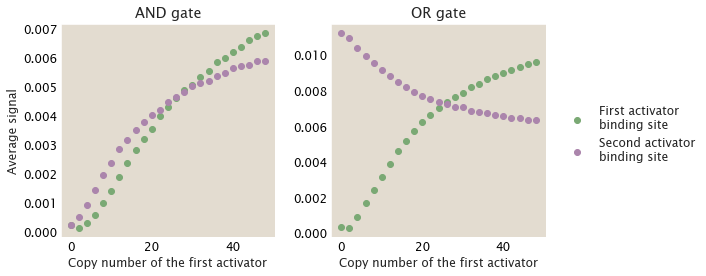

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
ax1, ax2 = axes

ax1.scatter(l_n_a1, a1_signal_AND, label='First activator\nbinding site', color='#7AA974')
ax1.scatter(l_n_a1, a2_signal_AND, label='Second activator\nbinding site', color='#AB85AC')
ax1.set_xlabel('Copy number of the first activator')
ax1.set_ylabel('Average signal')
ax1.set_title('AND gate')

ax2.scatter(l_n_a1, a1_signal_OR, label='First activator\nbinding site', color='#7AA974')
ax2.scatter(l_n_a1, a2_signal_OR, label='Second activator\nbinding site', color='#AB85AC')
ax2.set_xlabel('Copy number of the first activator')
ax2.set_title('OR gate')
ax2.legend(bbox_to_anchor=(1.04, 0.67), frameon=False)

plt.tight_layout()
plt.savefig('../../figs/knockout_doubleact.png', dpi=300)